## Create DA table with Teranet aggregates
This notebook contains the workflow to create a table of **Dissimination Areas (DAs)** with columns containing aggregates generated from Teranet dataset of real estate sales records (annual sales count, mean, median price).

Proposed structure of the table (each record is a DA):

### Proposed table structure

| DA id | Teranet 2017 count | ... | Teranet 1990 count |  
$\quad$|Teranet 2017 median price| ... | Teranet 1990 median price |  
$\quad$|Teranet 2017 mean price  | ... | Teranet 1990 mean price   |

In [42]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point

In [34]:
os.chdir('Documents/repos/geo/')
os.listdir()

['.git',
 '.gitattributes',
 '.gitignore',
 '.idea',
 '.ipynb_checkpoints',
 'arcgis.ipynb',
 'choropleth-map-example.png',
 'create_da_table.ipynb',
 'data',
 'geo_doodle.py',
 'my_functions_geo.py',
 'new_workflow.ipynb',
 'parking_Toronto.ipynb',
 'README.md',
 'Teranet_GTHA_DA_investigating_pins.ipynb',
 'Teranet_GTHA_DA_spatial_join.ipynb',
 'Teranet_GTHA_DA_workflow.ipynb',
 '__pycache__']

## DA data: profiles of income by DA from 2016 Census

In [7]:
da_geo_source = 'https://opendata.arcgis.com/datasets/9d262f8a576842fbb2afbc8c51a64178_1.geojson'
# da_geo_source = 'data/Profile_of_Income_by_Dissemination_Area__Greater_Toronto_Area_2016_Census.geojson'
da_income_gdf = gpd.read_file(da_geo_source)
da_income_gdf = da_income_gdf.set_index('OBJECTID')
print("GeoDataFrame 'da_income_gdf' with profile of income by dissimination areas created!")

GeoDataFrame 'da_income_gdf' with profile of income by dissimination areas created!


In [9]:
da_income_gdf.head(1)

,DAUID,CSDUID,CSDNAME,POP_TOT_INC,NUM_TOT_INC_PVT_HH,MEDIAN_TOT_INC,NUM_AFT_TAX_INC_PVT_HH,MEDIAN_AFT_INC,NUM_MKT_INC_PVT_HH,MEDIAN_MKT_INC,...,AVG_AFTER_TAX_INC_CPL_W_CHILD,TOT_INC_LONE_PARENT_25_SAMP,AVG_INC_LONE_PARENT,AVG_AFTER_TAX_LONE_PARENT,TOT_INC_NOT_IN_ECF_25_SAMP,AVG_INC_NOT_IN_ECF,AVG_AFTER_TAX_INC_NOT_IN_ECF,Shape__Area,Shape__Length,geometry
OBJECTID,,,,,,,,,,,,,,,,,,,,,
3001,35190147,3519046,Aurora,1845.0,1750.0,43221.0,1755.0,38187.0,1665.0,43669.0,...,176934.0,80.0,161886.0,116922.0,90.0,48426.0,40040.0,3.418148e+06,10579.683867,"POLYGON ((-79.461503331619 43.9741383351884, -..."


In [15]:
da_income_columns = ['DAUID', 'CSDNAME', 'POP_TOT_INC',
                     'MEDIAN_AFT_INC', 'AVG_AFT_INC', 
                     'Shape__Area', 'geometry']

In [16]:
da_gdf = da_income_gdf[da_income_columns]
da_gdf.head(1)

,DAUID,CSDNAME,POP_TOT_INC,MEDIAN_AFT_INC,AVG_AFT_INC,Shape__Area,geometry
OBJECTID,,,,,,,
3001,35190147,Aurora,1845.0,38187.0,53052.0,3.418148e+06,"POLYGON ((-79.461503331619 43.9741383351884, -..."


### Variable `POP_TOT_INC`: population by DA from 2016 Census

Text(0.5, 0.98, 'Total population by DA from 2016 Census (POP_TOT_INC)')

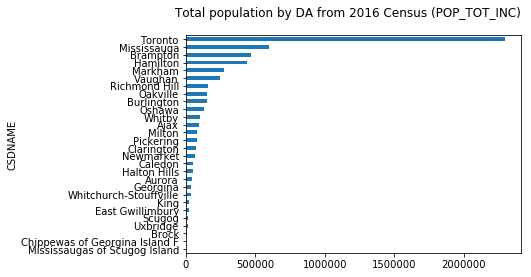

In [24]:
da_gdf.groupby('CSDNAME')['POP_TOT_INC'].sum().sort_values().plot(kind='barh')
plt.suptitle('Total population by DA from 2016 Census (POP_TOT_INC)')

### Variable `MEDIAN_AFT_INC`: median after-tax income by DA from 2016 Census

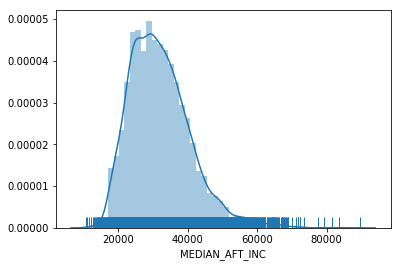

In [28]:
sns.distplot(da_gdf['MEDIAN_AFT_INC'].dropna(), rug=True)

### Variable `AVG_AFT_INC`: average after-tax income by DA from 2016 Census

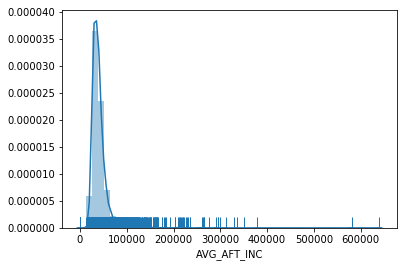

In [29]:
sns.distplot(da_gdf['AVG_AFT_INC'].dropna(), rug=True)

## Teranet data

With column `da_id` (renamed from `OBJECTID`) 
* produced via a spatial join of the points from the full cleaned Teranet dataset (`HHSaleHistory_cleaned_v0.9.csv`) with geometries of Dissimination Areas from York Region Municipal Government - Open Data (`bndDisseminationAreaGTHA2016` in DEM) accessed via ArcGIS Hub (same as GeoDataFrame of profiles of income by DA above). (https://hub.arcgis.com/datasets/9d262f8a576842fbb2afbc8c51a64178_1?selectedAttribute=TOT_HHTI_PVT)

In [69]:
# verify the path to Teranet dataset
teranet_path = 'data/HHSaleHistory_cleaned_v0.9_GTHA_DA.csv'
# read Teranet dataset with a column containing Dissimination Areas id
teranet_da_df = pd.read_csv(teranet_path)
# drop unnecessary columns
teranet_da_df.drop(['Unnamed: 0', 'index', 'index_right'], axis=1, inplace=True)
# covert 'registration_date' to datetime data format
teranet_da_df['registration_date'] = pd.to_datetime(teranet_da_df['registration_date'])
teranet_da_df = teranet_da_df.set_index('registration_date')
teranet_da_df = teranet_da_df.sort_index()
print("Teranet sales data with 'da_id' was loaded into DataFrame 'teranet_da_df'!")
print("{0:,} records total in the DataFrame.".format(len(teranet_da_df)))

Teranet sales data with 'da_id' was loaded into DataFrame 'teranet_da_df'!
6,062,853 records total in the DataFrame.


### Validating consistency of DA `geometry` from Census and `da_id` in Teranet records 

In [71]:
# combine values in columns 'x' and 'y' into a POINT geometry object
# Point() is a function imported from shapely.geometry
geometry = [Point(xy) for xy in zip(teranet_da_df['x'], teranet_da_df['y'])]

# generate a new GeoDataFrame by adding point geometry to data frame 'teranet_sales_data'
teranet_sales_gdf = gpd.GeoDataFrame(teranet_da_df, geometry=geometry)
print("Geometry generated from 'x' and 'y' pairs, GeoDataFrame created!")

Geometry generated from 'x' and 'y' pairs, GeoDataFrame created!


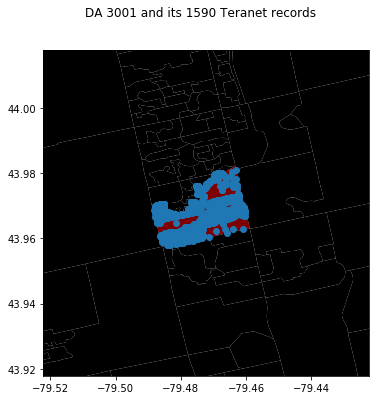

In [81]:
focus_id = da_income_gdf.index[0] # index of focus polygon
focus_rad = 0.05 # ratio to zoom the map on focus polygon
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot base layer of polygons
da_income_gdf.plot(ax=ax, facecolor='black',
                       linewidth=0.1, alpha=1)
# Select focal polygon
focus = da_income_gdf.loc[[focus_id], 'geometry']
# Plot focal polygon
focus.plot(ax=ax, facecolor='red', linewidth=0, alpha=0.5)
# Subset and plot Teranet records from focus DA
mask = teranet_sales_gdf['da_id'] == focus_id
teranet_subset = teranet_sales_gdf[mask]
teranet_subset.plot(ax=ax)
# Title
f.suptitle("DA {0} and its {1:,} Teranet records"
           .format(focus_id, sum(mask)))
# Style and display on screen
ax.set_ylim(focus.centroid.y.iloc[0] - focus_rad, focus.centroid.y.iloc[0] + focus_rad)
ax.set_xlim(focus.centroid.x.iloc[0] - focus_rad, focus.centroid.x.iloc[0] + focus_rad)
plt.show()

## Resample Teranet data per year per DA

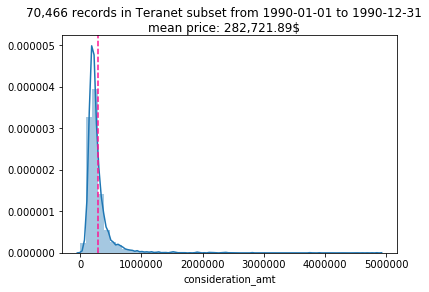

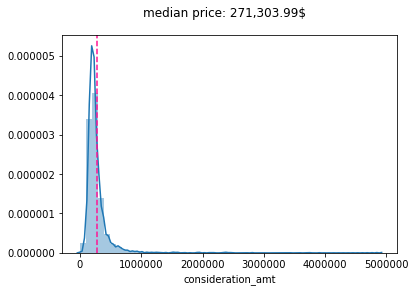

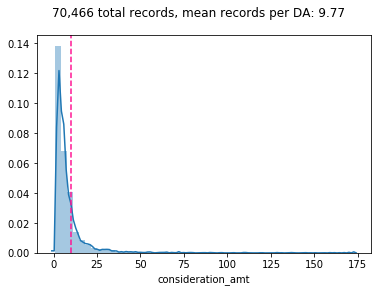

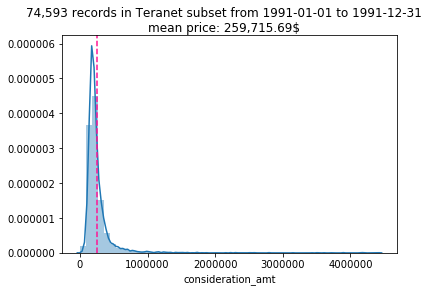

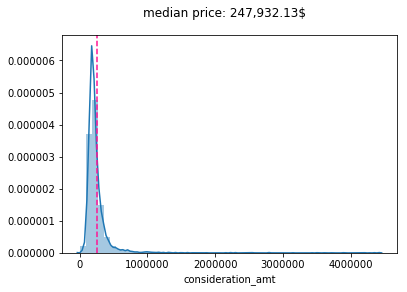

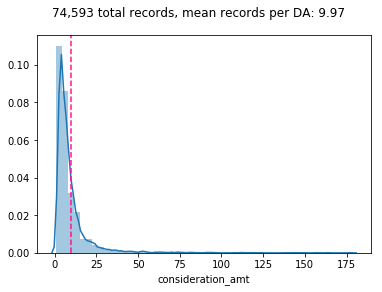

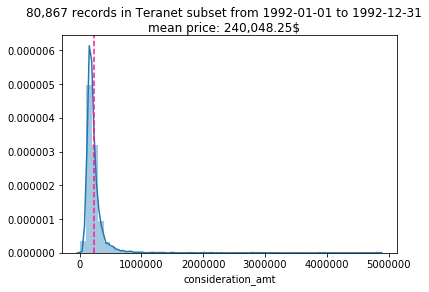

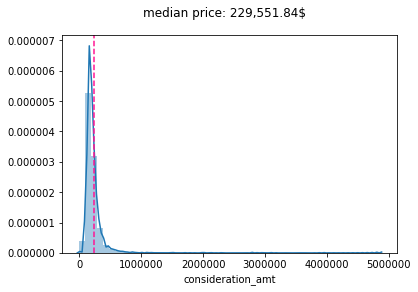

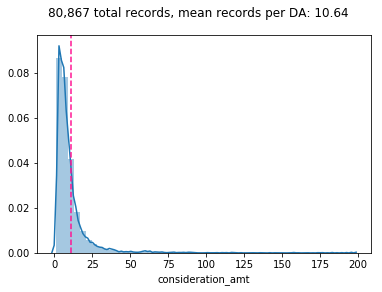

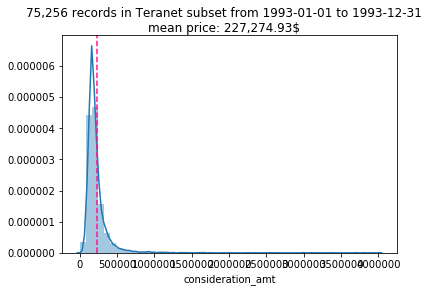

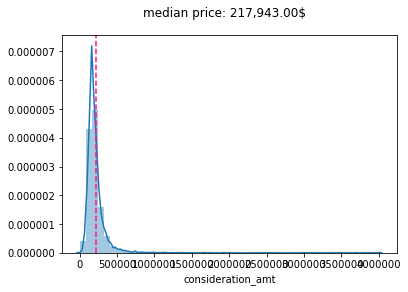

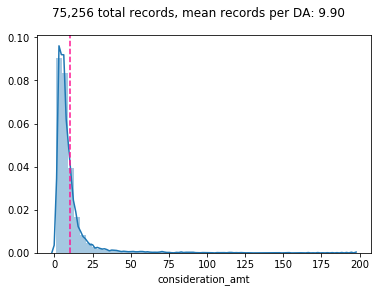

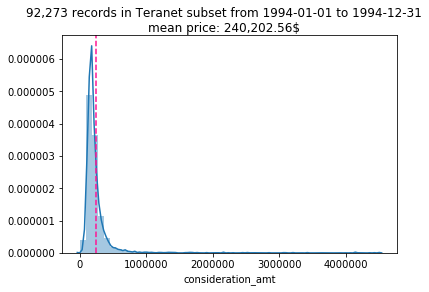

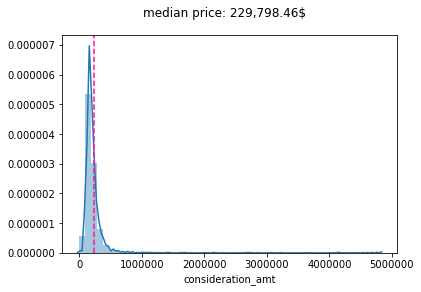

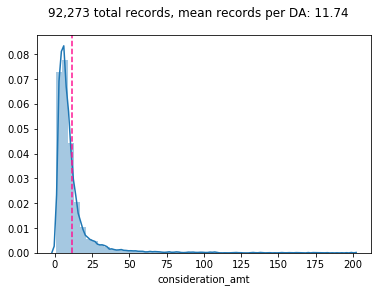

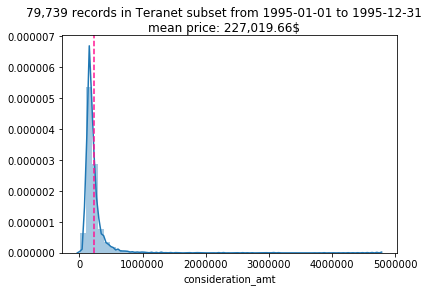

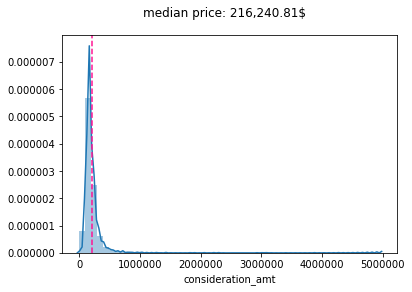

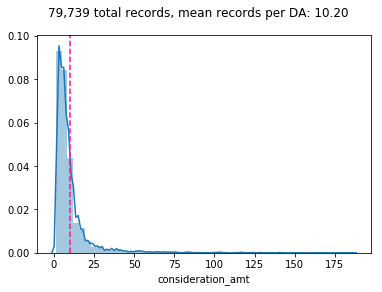

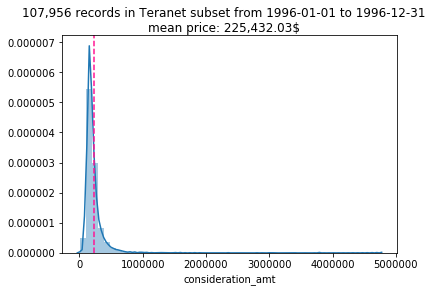

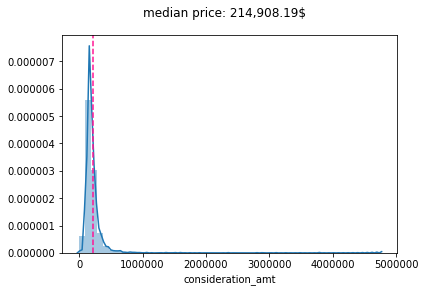

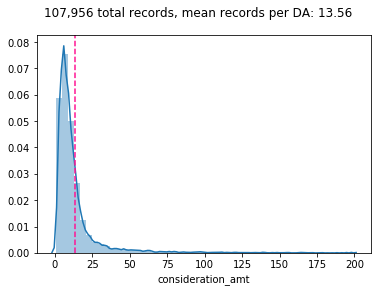

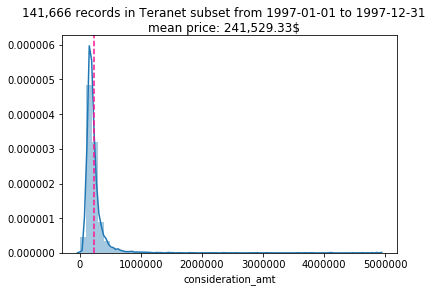

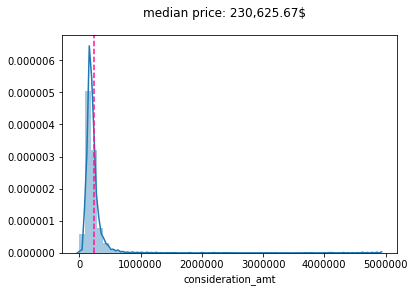

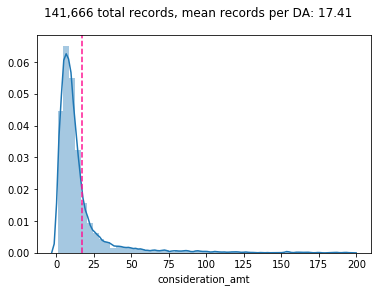

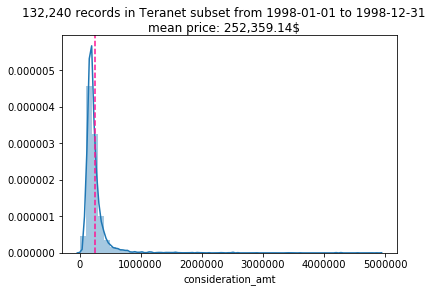

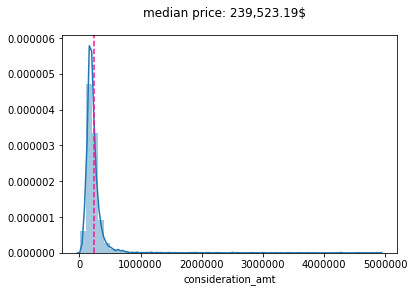

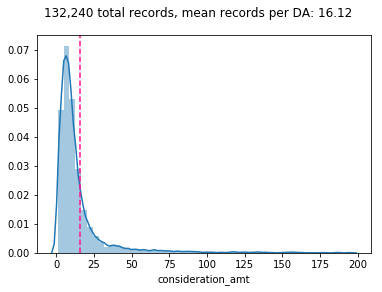

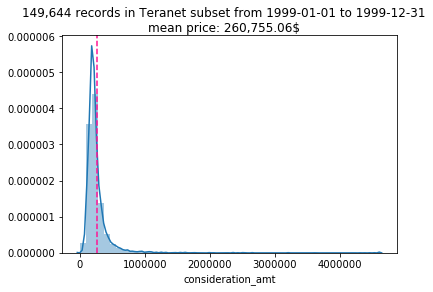

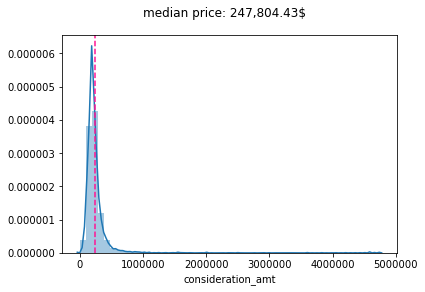

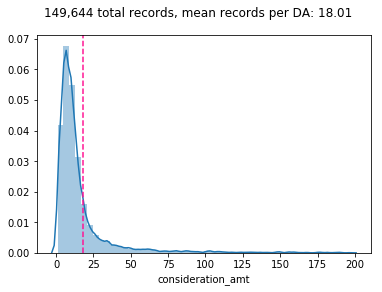

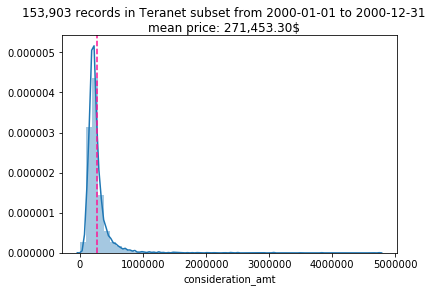

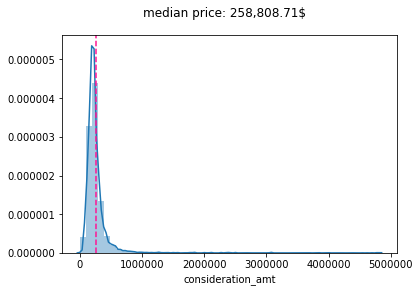

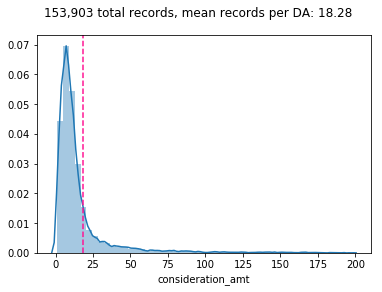

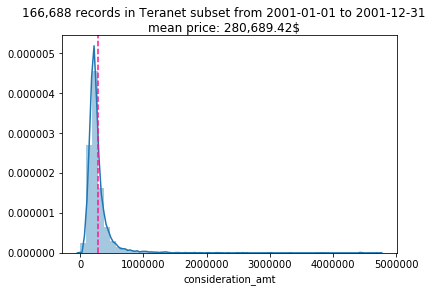

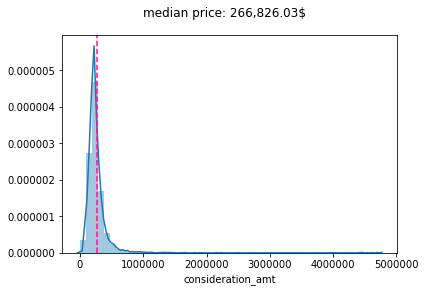

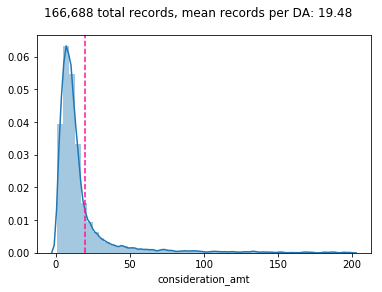

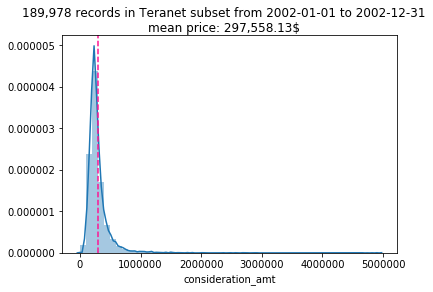

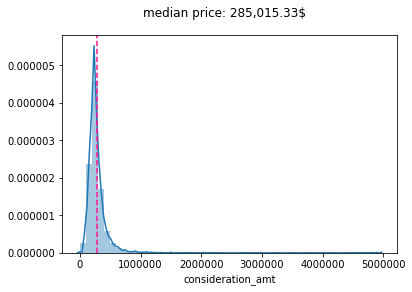

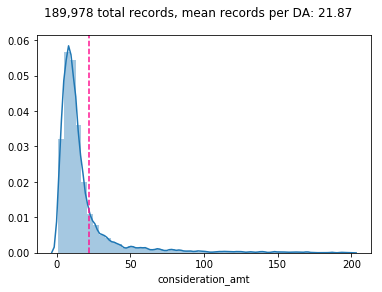

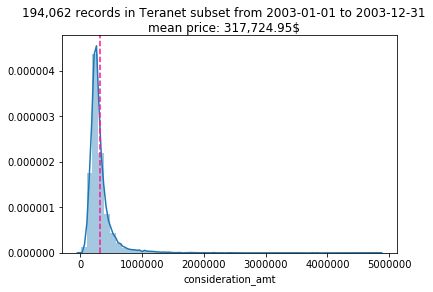

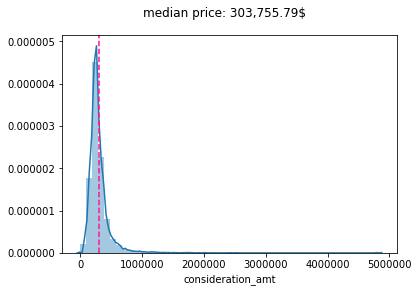

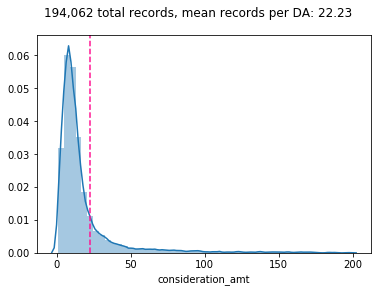

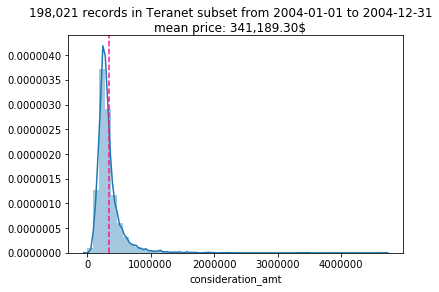

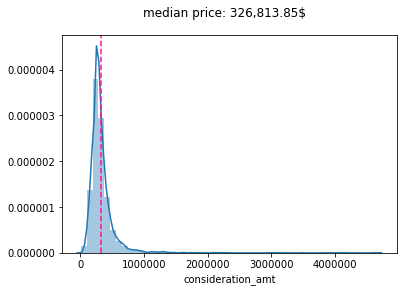

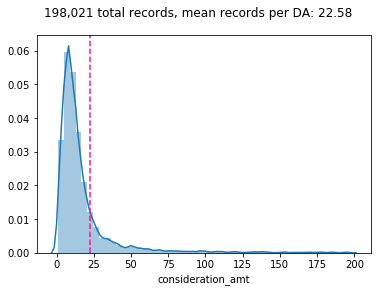

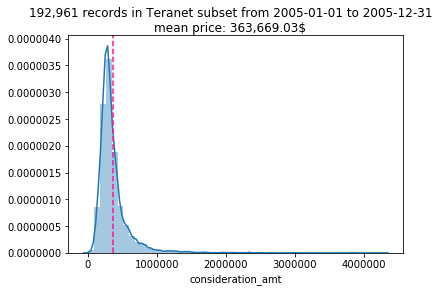

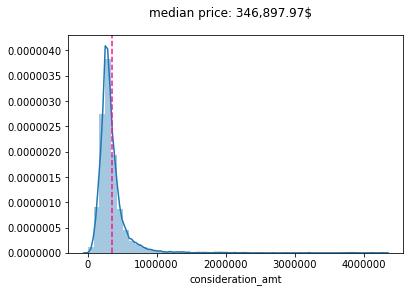

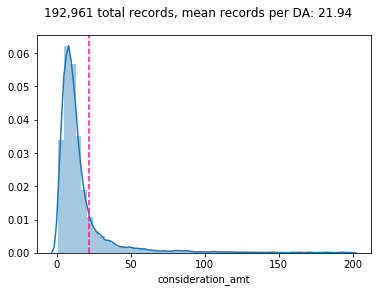

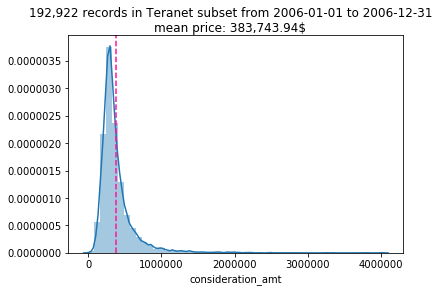

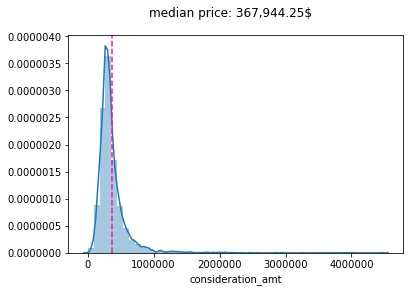

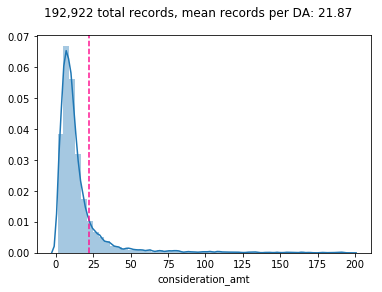

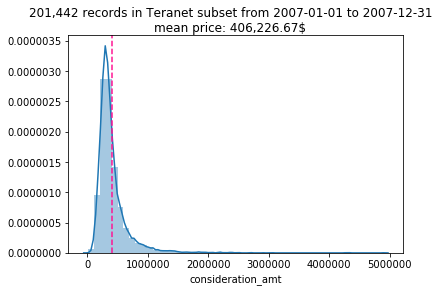

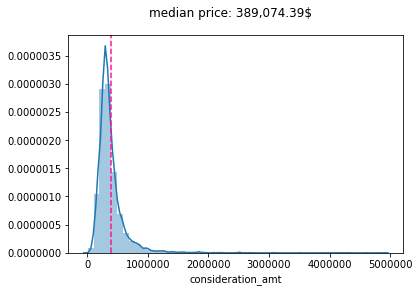

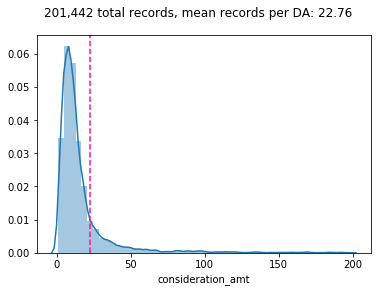

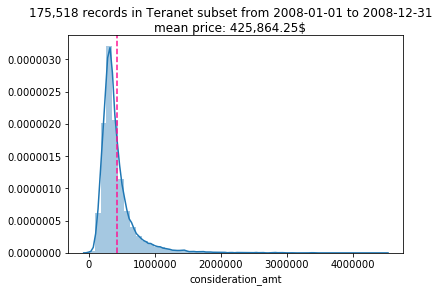

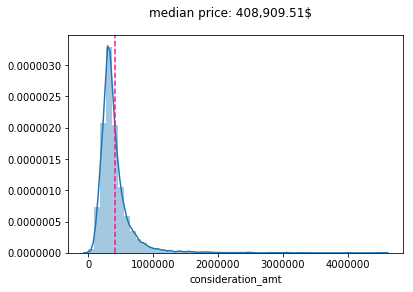

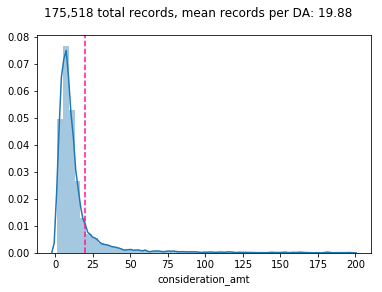

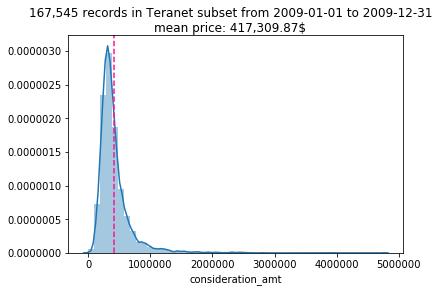

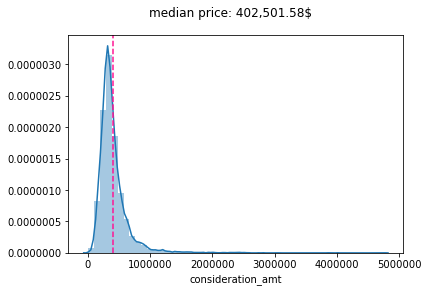

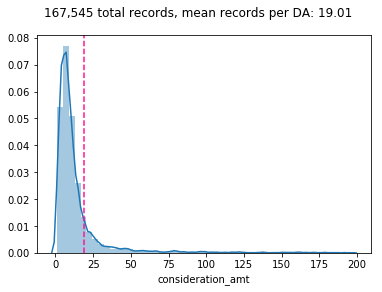

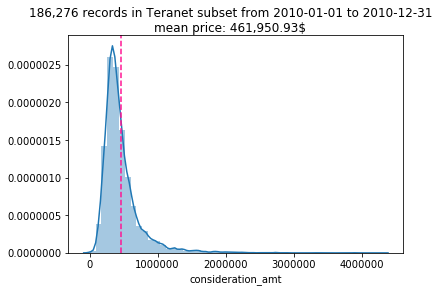

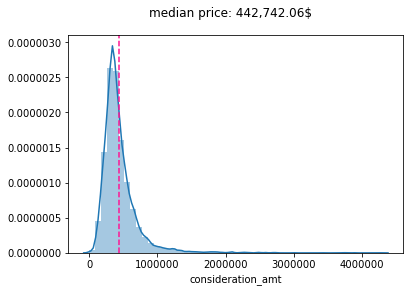

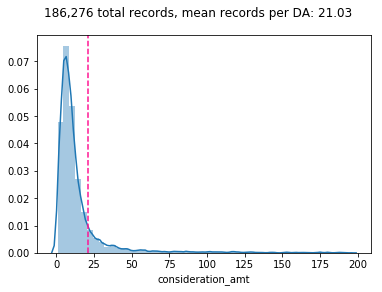

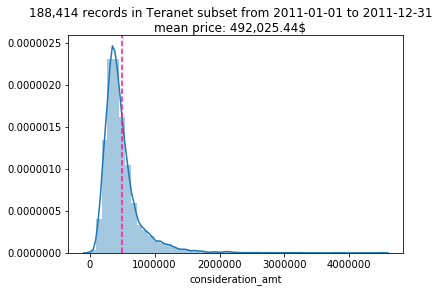

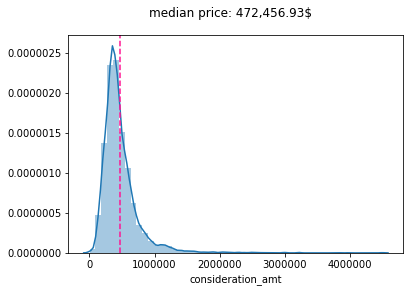

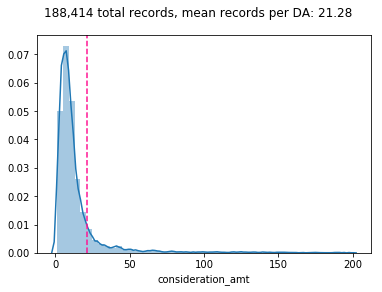

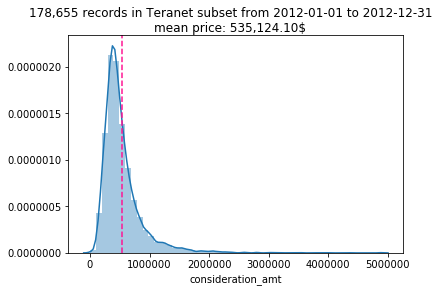

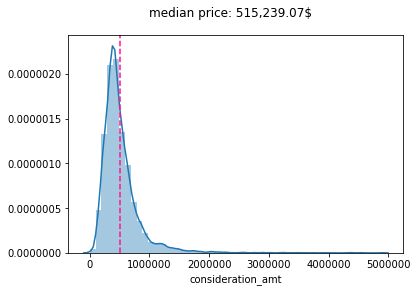

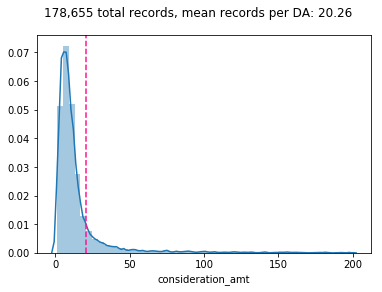

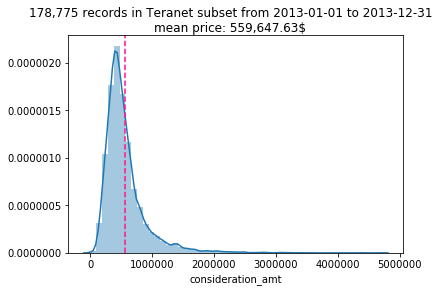

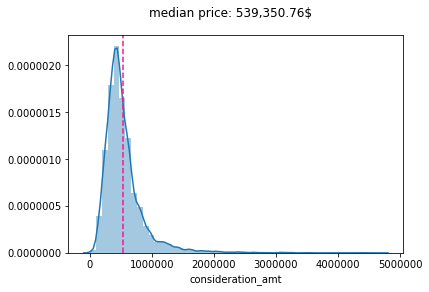

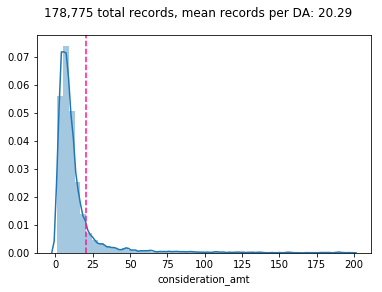

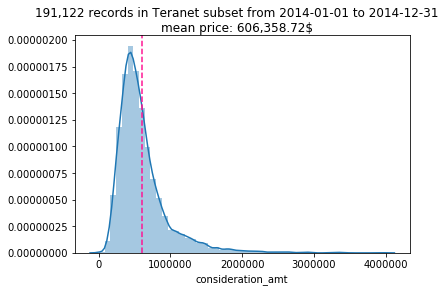

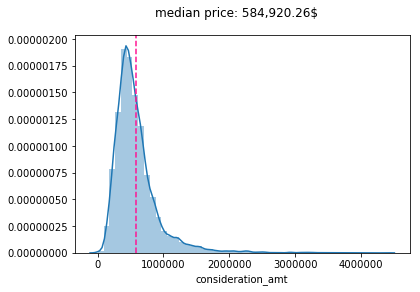

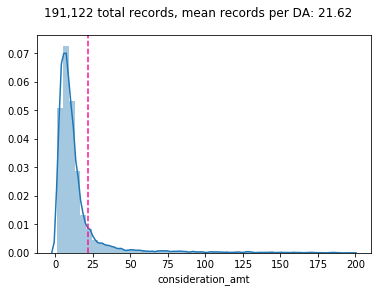

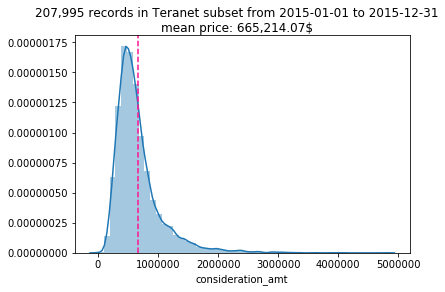

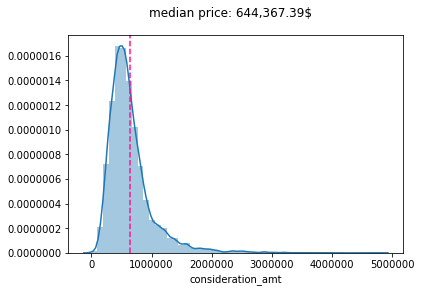

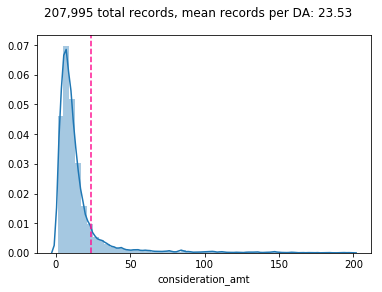

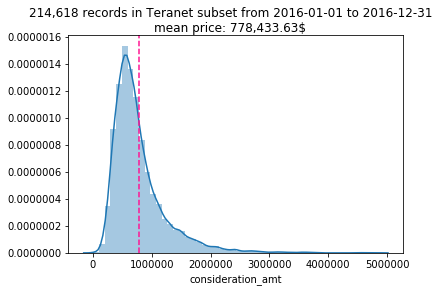

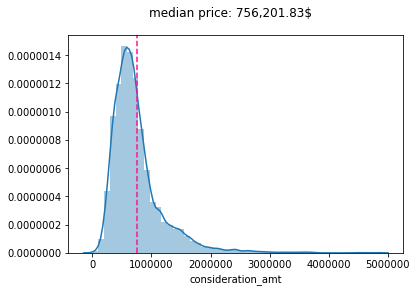

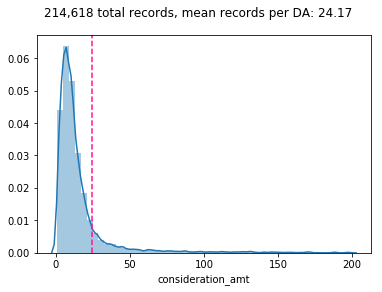

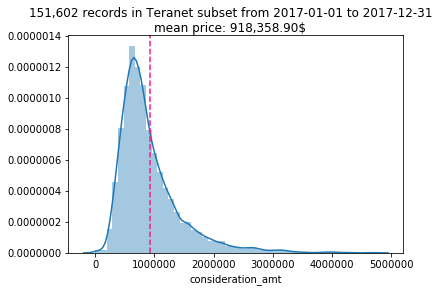

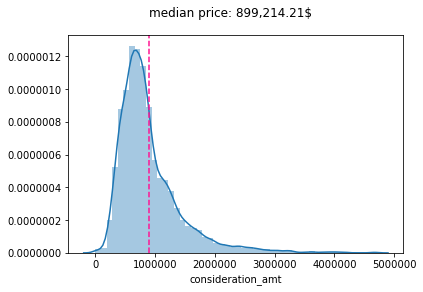

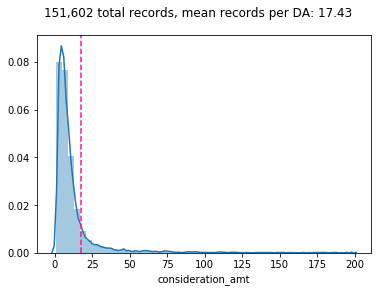

Yearly (from 1990 to 2017) record count, mean and median price derived from Teranet data has been added to GeoDataFrame 'da_gdf'!


In [159]:
# Create annual subsets of Teranet records
first_year = 1990
final_year = 2017
year_range = list(range(first_year, final_year + 1))
# min and max price to filter outliers
min_price = 1000
max_price = 5000000
# loop over each year in the range, generate Teranet aggregates
for year in year_range:
    # set subset interval
    start_date = str(year) + '-01-01'
    end_date = str(year) + '-12-31'
    # subset Teranet data
    teranet_subset = \
        teranet_da_df[start_date:end_date].dropna(subset=['consideration_amt'])
    # remove outliers, 1'000 < price < 5'000'000
    mask1 = teranet_subset['consideration_amt'] > min_price
    mask2 = teranet_subset['consideration_amt'] < max_price
    teranet_subset = teranet_subset[mask1 & mask2]
    # generate count, mean and median price per DA from Teranet subset
    da_groups = teranet_subset.groupby('da_id')
    record_count = da_groups['consideration_amt'].count()
    mean_price = da_groups['consideration_amt'].mean()
    median_price = da_groups['consideration_amt'].median()
    # plot distributions 
    sns.distplot(mean_price)
    plt.axvline(mean_price.mean(), color='deeppink', linestyle='--')
    plt.suptitle("{0:,} records in Teranet subset from {1} to {2}"
                 .format(len(teranet_subset), start_date, end_date)
                 + "\nmean price: {0:,.2f}$".format(mean_price.mean()))
    plt.show()
    sns.distplot(median_price)
    plt.axvline(median_price.mean(), color='deeppink', linestyle='--')
    plt.suptitle("median price: {0:,.2f}$".format(median_price.mean()))
    plt.show()
    # remove outliers by record count (for display only)
    record_count_no = record_count[record_count < 200]
    sns.distplot(record_count_no)
    plt.axvline(record_count.mean(), color='deeppink', linestyle='--')
    plt.suptitle("{0:,} total records, mean records per DA: {1:,.2f}"
                 .format(record_count.sum(), record_count.mean()))
    plt.show()
    # save Teranet aggregates to GeoDataFrame 'da_gdf'
    da_gdf = da_gdf.join(mean_price)
    da_gdf = \
        da_gdf.rename(columns={'consideration_amt':'ter_ca_avg_' 
                                                   + str(year)})
    da_gdf = da_gdf.join(median_price)
    da_gdf = \
        da_gdf.rename(columns={'consideration_amt':'ter_ca_med_' 
                                                   + str(year)})
    da_gdf = da_gdf.join(record_count)    
    da_gdf = \
        da_gdf.rename(columns={'consideration_amt':'ter_count_' 
                                                   + str(year)})
print("Yearly (from {0} to {1}) record count, mean and median "
      .format(year_range[0], year_range[-1]) + 
      "price derived from Teranet data "
      "has been added to GeoDataFrame 'da_gdf'!")

In [160]:
da_gdf.head(1)

,DAUID,CSDNAME,POP_TOT_INC,MEDIAN_AFT_INC,AVG_AFT_INC,Shape__Area,geometry,ter_ca_avg_1990,ter_ca_med_1990,ter_count_1990,...,ter_count_2014,ter_ca_avg_2015,ter_ca_med_2015,ter_count_2015,ter_ca_avg_2016,ter_ca_med_2016,ter_count_2016,ter_ca_avg_2017,ter_ca_med_2017,ter_count_2017
OBJECTID,,,,,,,,,,,,,,,,,,,,,
3001,35190147,Aurora,1845.0,38187.0,53052.0,3.418148e+06,"POLYGON ((-79.461503331619 43.9741383351884, -...",474879.190476,269990.0,21.0,...,36.0,1.227830e+06,855000.0,37.0,1.284316e+06,1165500.0,52.0,1.547534e+06,1380000.0,35.0


### Sanity check: relationship between DA population and count of Teranet records

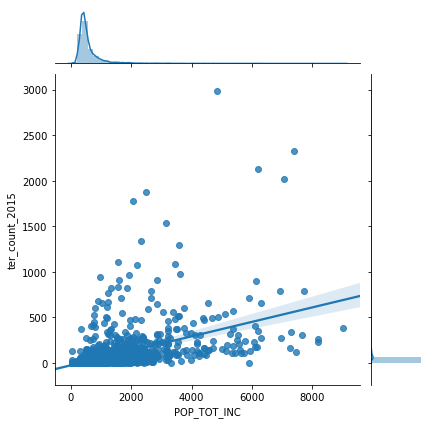

In [163]:
sns.jointplot(data=da_gdf, kind='reg',
              x='POP_TOT_INC', y='ter_count_2015')

In [178]:
# reorder columns
old_cols = list(da_gdf.columns[:7])
new_cols_avg = ['ter_ca_avg_' + str(year) for year in list(range(first_year, final_year + 1))]
new_cols_med = ['ter_ca_med_' + str(year) for year in list(range(first_year, final_year + 1))]
new_cols_cnt = ['ter_count_' + str(year) for year in list(range(first_year, final_year + 1))]
new_cols = new_cols_med + new_cols_avg + new_cols_cnt
cols = old_cols + new_cols
da_gdf[cols].head(1)

,DAUID,CSDNAME,POP_TOT_INC,MEDIAN_AFT_INC,AVG_AFT_INC,Shape__Area,geometry,ter_ca_med_1990,ter_ca_med_1991,ter_ca_med_1992,...,ter_count_2008,ter_count_2009,ter_count_2010,ter_count_2011,ter_count_2012,ter_count_2013,ter_count_2014,ter_count_2015,ter_count_2016,ter_count_2017
OBJECTID,,,,,,,,,,,,,,,,,,,,,
3001,35190147,Aurora,1845.0,38187.0,53052.0,3.418148e+06,"POLYGON ((-79.461503331619 43.9741383351884, -...",269990.0,240990.0,269574.5,...,35.0,59.0,79.0,48.0,34.0,38.0,36.0,37.0,52.0,35.0


In [181]:
csv_save_file_path = 'data/da_teranet_1990_2017.csv'
# save GeoDataFrame to a .csv file without the 'geometry' and 'index_right' columns
da_gdf.reset_index().drop(['geometry'], axis=1).to_csv(csv_save_file_path)
print("GeoDataFrame 'da_gdf' recorded without geometry to file {0}!"
      .format(csv_save_file_path))

GeoDataFrame 'da_gdf' recorded without geometry to file data/da_teranet_1990_2017.csv!
